In [5]:
import numpy as np
import pandas as pd
import sqlite3
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [7]:
mydb = mysql.connector.connect(host='localhost', port='3306', user='root', passwd='Samsungstar@5', db="soccermanagementsystem", auth_plugin='mysql_native_password', buffered=True)

In [8]:
mycursor = mydb.cursor()

In [9]:
mycursor.execute("SHOW DATABASES")

for x in mycursor:
    print(x)

('information_schema',)
('mysql',)
('performance_schema',)
('soccermanagementsystem',)
('sys',)


In [10]:
mycursor.execute("SHOW TABLES")

In [11]:
for x in mycursor:
    print(x)

('country',)
('league',)
('match',)
('player_attributes',)
('players',)
('teams',)


# How are the different player attributes related to each other?

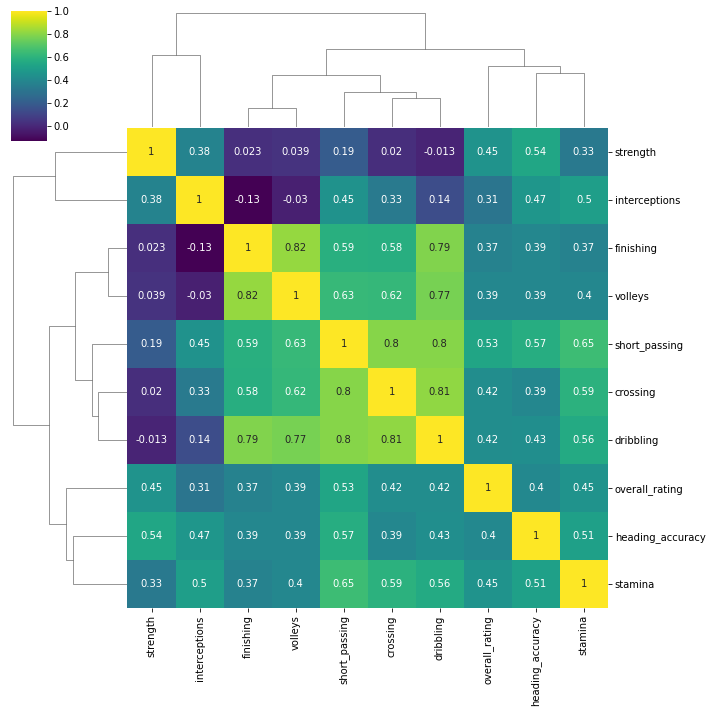

In [12]:
e = mycursor.execute("Select overall_rating, preferred_foot, crossing, finishing, heading_accuracy, short_passing, volleys, dribbling, stamina, strength, interceptions from player_attributes")
mycursor.execute(e)
myresult4 = mycursor.fetchall()
Query3 = pd.DataFrame(myresult4, columns = ["overall_rating", "preferred_foot", "crossing", "finishing", "heading_accuracy", "short_passing", "volleys", "dribbling", "stamina", "strength", "interceptions"])
sns.clustermap(Query3.corr(), annot=True,cmap='viridis')


# How does the calculated height of players impact their average overall rating in the dataset?

Text(0.5, 1.0, 'Potential vs Height')

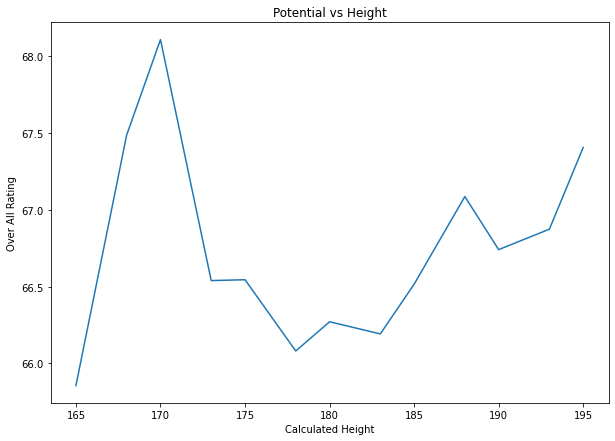

In [13]:
a = mycursor.execute("SELECT CASE WHEN ROUND(height)<165 then 165 WHEN ROUND(height)>195 then 195 ELSE ROUND(height) END AS calc_height, COUNT(height) AS distribution,  (avg(PA_Grouped.avg_overall_rating)) AS avg_overall_rating, (avg(PA_Grouped.avg_potential)) AS avg_potential, AVG(weight) AS avg_weight  FROM PLAYERS LEFT JOIN (SELECT Player_Attributes.player_id,  avg(Player_Attributes.overall_rating) AS avg_overall_rating, avg(Player_Attributes.potential) AS avg_potential   FROM Player_Attributes GROUP BY Player_Attributes.player_id)  AS PA_Grouped ON PLAYERS.player_api_id = PA_Grouped.player_id GROUP BY calc_height ORDER BY calc_height")
mycursor.execute(a)
myresult = mycursor.fetchall()
players_height = pd.DataFrame(myresult, columns=['calc_height','distribution','avg_overall_rating','avg_potential','avg_weight'])
players_height = players_height.reset_index(drop=True)
plt.figure(figsize=(10,7))
plt.plot(players_height['calc_height'], players_height['avg_overall_rating'])
plt.xlabel('Calculated Height') 
plt.ylabel('Over All Rating')
plt.title("Potential vs Height")

# Is there a significant difference in the average ratings between players who prefer their left foot versus those who prefer their right foot?

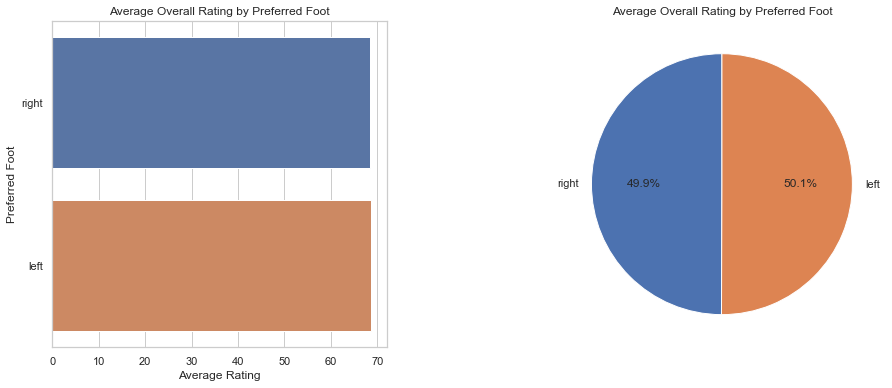

In [14]:
b = mycursor.execute("SELECT preferred_foot, AVG(overall_rating) AS average_rating FROM player_attributes GROUP BY preferred_foot")
mycursor.execute(b)
myresult1 = mycursor.fetchall()
Query2 = pd.DataFrame(myresult1, columns=['Preferred Foot', 'Average Rating']).reset_index(drop=True)
Query2 = Query2.iloc[:2,:2]

sns.set(style='whitegrid')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(x='Average Rating', y='Preferred Foot', data=Query2, ci=None, ax=ax1)
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Preferred Foot')
ax1.set_title('Average Overall Rating by Preferred Foot')

labels = Query2['Preferred Foot']
sizes = Query2['Average Rating']
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Average Overall Rating by Preferred Foot')

plt.subplots_adjust(wspace=0.5)

plt.show()


# Is there a relationship between a player's overall rating and their finishing ability?

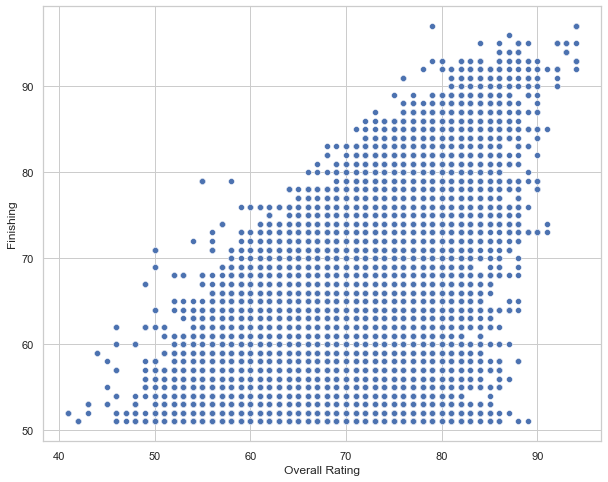

In [15]:
d = mycursor.execute("Select overall_rating, finishing from player_attributes having overall_rating > 0 and finishing > 50 ")
mycursor.execute(d)
myresult3 = mycursor.fetchall()
Query2 = pd.DataFrame(myresult3, columns =['Overall Rating', 'Finishing']).reset_index(drop = True)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Overall Rating', y='Finishing', data=Query2)
plt.show()


# Number of Matches Played By League

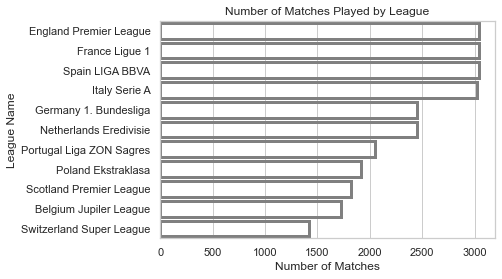

In [16]:
query = "SELECT l.league_name, COUNT(m.match_id) AS num_matches FROM league l JOIN `Match` m ON l.league_id = m.league_id GROUP BY l.league_name ORDER BY num_matches DESC"

mycursor.execute(query)
myresult = mycursor.fetchall()

df = pd.DataFrame(myresult, columns=['Name', 'Number of Match'])
sns.barplot(x='Number of Match', y='Name', data=df, capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

plt.xlabel('Number of Matches')
plt.ylabel('League Name')
plt.title('Number of Matches Played by League')

plt.show()


# Number of Matches Played by teams per Month

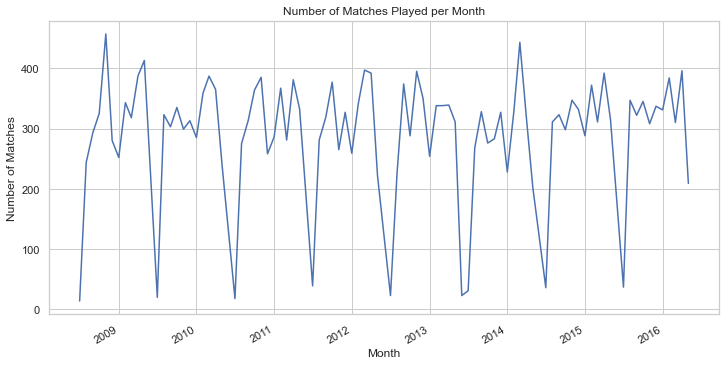

In [17]:
mycursor.execute('SELECT DATE_FORMAT(m.match_date, "%Y-%m") AS month, COUNT(m.match_id) AS num_matches FROM `Match` m GROUP BY month ORDER BY month DESC')

df = pd.DataFrame(mycursor.fetchall(), columns=['month', 'num_matches'])

df['month'] = pd.to_datetime(df['month'])
df.set_index('month', inplace=True)

ax = df.plot(kind='line', figsize=(12, 6), legend=None)

ax.set_xlabel('Month')
ax.set_ylabel('Number of Matches')
ax.set_title('Number of Matches Played per Month')

plt.show()


# Which football teams have played the most matches and what is their win percentage? 

/var/folders/79/vzbflgns5357xhzs356s30q00000gn/T/ipykernel_43544/4209205377.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['team_long_name'], rotation=90)


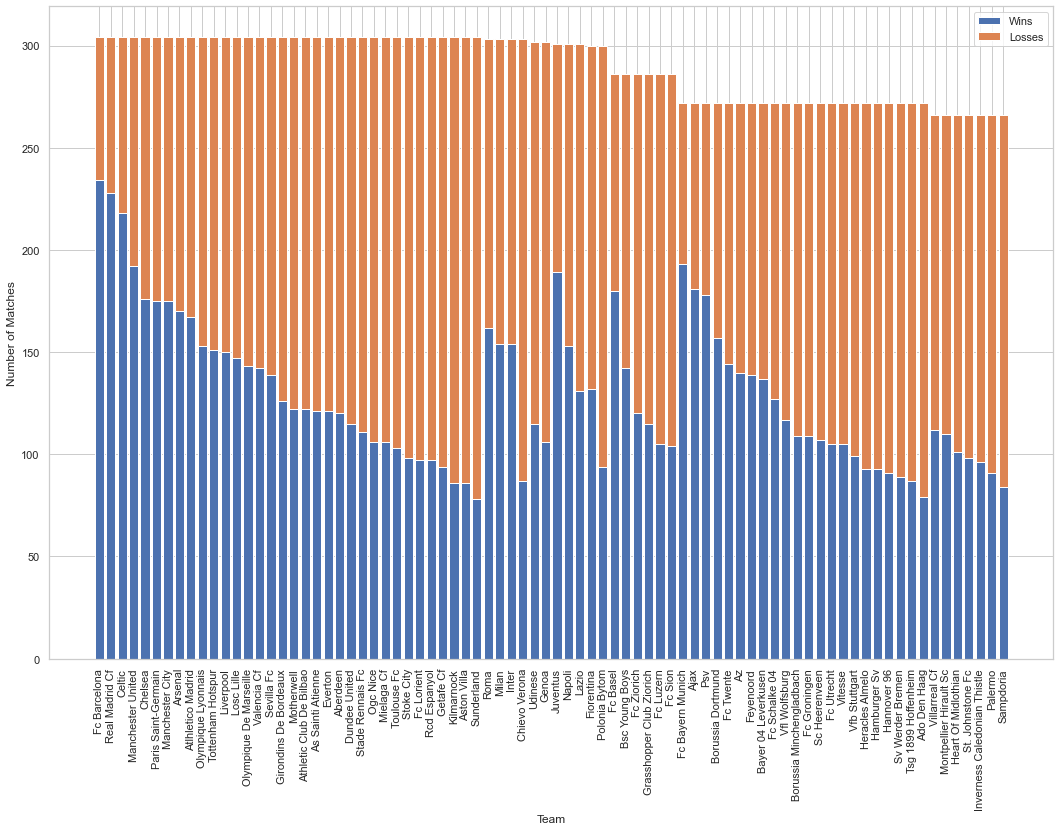

In [18]:
query = """
SELECT t.team_long_name, COUNT(m.match_id) AS num_matches, 
    SUM(CASE WHEN m.home_team_goal > m.away_team_goal AND m.home_team_id = t.team_id THEN 1 
        WHEN m.away_team_goal > m.home_team_goal AND m.away_team_id = t.team_id THEN 1 
        ELSE 0 END) AS num_wins
FROM teams t
LEFT JOIN `Match` m ON t.team_id = m.home_team_id OR t.team_id = m.away_team_id
GROUP BY t.team_long_name
ORDER BY num_matches DESC, num_wins DESC Limit 80;
"""

df = pd.read_sql_query(query, mydb)
df['num_losses'] = df['num_matches'] - df['num_wins']
df['win_percent'] = df['num_wins'] / df['num_matches'] * 100

fig, ax = plt.subplots(figsize=(18, 12))
ax.bar(df['team_long_name'], df['num_wins'], label='Wins')
ax.bar(df['team_long_name'], df['num_losses'], bottom=df['num_wins'], label='Losses')
ax.set_xticklabels(df['team_long_name'], rotation=90)
ax.set_xlabel('Team')
ax.set_ylabel('Number of Matches')
ax.legend()
plt.show()
